In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Step1: Exploratory Climate Analysis

### Precipitation Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date = max_date[0]
one_year = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query, columns=["date", "precipitation"])
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)
precipitation_df.head()


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


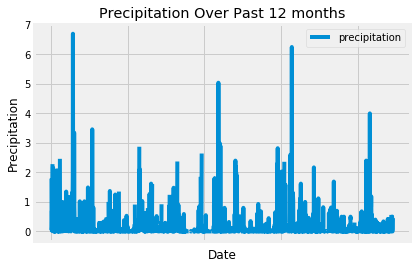

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.title("Precipitation Over Past 12 months")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend(loc="upper right")

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [13]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
print(f"Number of available stations: {stations} ")

Number of available stations: 9 


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, 
                                func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"The most active stations are: ")
active_stations

The most active stations are: 


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = active_stations[0][0]

min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active).all()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active).all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()

print(f"At the most active station: the lowest temp is: {min_temp[0][0]}, highest temp is: {min_temp[0][0]}, average temp is {round(avg_temp[0][0], 2)}")

At the most active station: the lowest temp is: 54.0, highest temp is: 54.0, average temp is 71.66


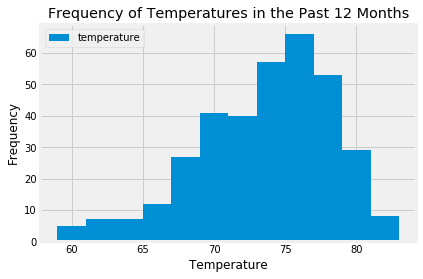

In [16]:
# Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obvs = session.query(Measurement.tobs).filter(Measurement.date >= one_year).filter(Measurement.station == most_temps_station).all()
temp_obvs = pd.DataFrame(temp_obvs, columns=['temperature'])

temp_obvs.plot.hist(bins=12)

plt.title("Frequency of Temperatures in the Past 12 Months")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc="upper left")

# Step 2: Climate App

In [1]:
from flask import Flask, json, jsonify
app = Flask(__name__)

In [ ]:
#homepage
#list of routes available

@app.route('/')
def home():
    return(
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation"
        f"/api/v1.0/stations"
        f"/api/v1.0/tobs"
        f"/api/v1.0/<start>"
        f"/api/v1.0/<start>/<end>")

In [ ]:
#Convert the query results to a Dictionary using date as the key and prcp as the value.
#Return the JSON representation of your dictionary.

@app.route('/api/v1.0/precipitation')
def precipitation():
    prcp_results = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.date >= one_year).all()
    prcp_dict = dict(prcp_results)
    print("Results for Precipitation")
    return jsonify(prcp_dict)

In [ ]:
#Return a JSON list of stations from the dataset.

@app.route('/api/v1.0/stations/')
def stations():
    station_list = session.query(Station.station).all() 
    print("Station List:")   
    for row in station_list:
        print (row[0])
    return jsonify(station_list)

In [ ]:
#query for the dates and temperature observations from a year from the last data point.
#Return a JSON list of Temperature Observations (tobs) for the previous year.

@app.route("/api/v1.0/tobs")
def tobs():
    temp_obs = session.query(Measurement.tobs)\
    .order_by(Measurement.date >= one_year).all()
    print("Temperature Results for All Stations")
    return jsonify(temp_obs)

In [ ]:
#Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.
#When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
#When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.

@app.route("/api/v1.0/<start>")
def combined_start_stats(start):
    q = session.query(Station.id,
                  Station.station,
                  func.min(Measurement.tobs),
                  func.max(Measurement.tobs),
                  func.avg(Measurement.tobs))\
                  .filter(Measurement.station == Station.station)\
                  .filter(Measurement.date >= start).all()                  
    print("Query Temps Combinded Stations with Start ({start}) Date")
    for row in q:
        print()
        print(row)
    return jsonify(q)

In [ ]:
@app.route("/api/v1.0/<start>/<end>")

def combined_start_end_stats(start,end):
    q = session.query(Station.id,
                  Station.station,
                  func.min(Measurement.tobs),
                  func.max(Measurement.tobs),
                  func.avg(Measurement.tobs))\
                  .filter(Measurement.station == Station.station)\
                  .filter(Measurement.date <= end)\
                  .filter(Measurement.date >= start).all()
    print(f"Query Temps Combined Stations with Start ({start}) and End ({end}) Date")
    for row in q:
        print()
        print(row)
    return jsonify(q)


if __name__ == '__main__':
    app.run(debug=True)